### 输出运行设备名称

In [1]:
import tensorflow as tf

a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
c = a + b

# 通过log_device_placement参数来输出运行每一个运算的设备
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess.run(c))

[ 2.  4.  6.]


### 指定运行设备

In [2]:
import tensorflow as tf

# 通过tf.device将运算指定到特定的设备上。
with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
with tf.device('/gpu:0'):
    c = a + b

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess.run(c))

[ 2.  4.  6.]


### 软指定运行设备

In [4]:
import tensorflow as tf

a_cpu = tf.Variable(0, name='a_cpu')
with tf.device('/gpu:0'):
    a_cpu = tf.Variable(0, name='a_gpu')
    
# 通过allow_soft_palcement参数自动将无法放在GPU上的操作放回CPU上
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

sess.run(tf.initialize_all_variables())

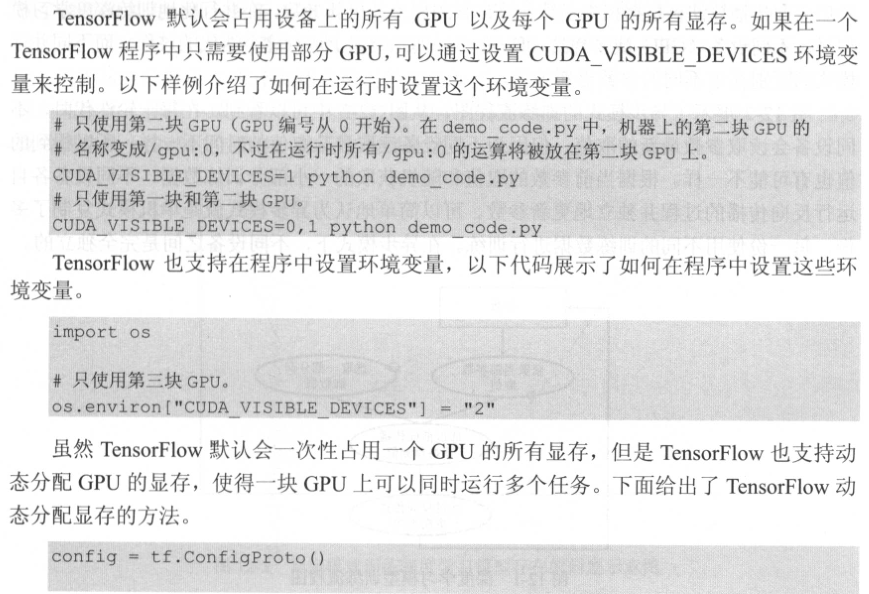

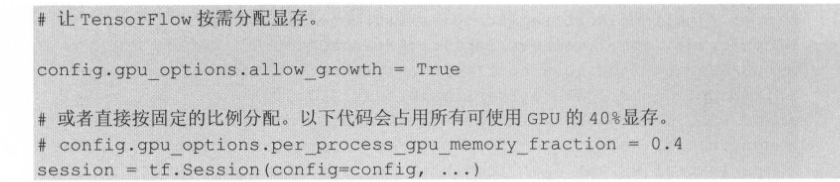

# 深度学习训练并行模式

In [1]:
import tensorflow as tf

INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500

def get_weight_variable(shape, regularizer):
    weights = tf.get_variable("weights",
                              shape,
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    if regularizer != None: 
        tf.add_to_collection('losses', regularizer(weights))
        
    return weights


def inference(input_tensor, regularizer):
    with tf.variable_scope('layer1'):
        weights = get_weight_variable([INPUT_NODE, LAYER1_NODE], regularizer)
        biases = tf.get_variable("biases",
                                 [LAYER1_NODE],
                                 initializer=tf.constant_initializer(0.0))
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + biases)

    with tf.variable_scope('layer2'):
        weights = get_weight_variable([LAYER1_NODE, OUTPUT_NODE], regularizer)
        biases = tf.get_variable("biases",
                                 [OUTPUT_NODE],
                                 initializer=tf.constant_initializer(0.0))
        layer2 = tf.matmul(layer1, weights) + biases

    return layer2

In [ ]:
# coding=utf-8
from datetime import datetime
import os
import time

import tensorflow as tf

# 定义训练神经网络时需要用到的参数。
BATCH_SIZE = 100 
LEARNING_RATE_BASE = 0.001
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 1000
MOVING_AVERAGE_DECAY = 0.99 
N_GPU = 2

# 定义日志和模型输出的路径。
MODEL_SAVE_PATH = "log/"
MODEL_NAME = "model.ckpt"

# 定义数据存储的路径。因为需要为不同的GPU提供不同的训练数据，所以通过placerholder
# 的方式就需要手动准备多份数据。为了方便训练数据的获取过程，可以采用第7章中介绍的Dataset
# 的方式从TFRecord中读取数据。于是在这里提供的数据文件路径为将MNIST训练数据
# 转化为TFRecords格式之后的路径。如何将MNIST数据转化为TFRecord格式在第7章中有
# 详细介绍，这里不再赘述。
DATA_PATH = "output.tfrecords" 

# 定义输入队列得到训练数据
def get_input():
    dataset = tf.data.TFRecordDataset([DATA_PATH])

    # 定义数据解析格式。
    def parser(record):
        features = tf.parse_single_example(
            record,
            features={
                'image_raw': tf.FixedLenFeature([], tf.string),
                'pixels': tf.FixedLenFeature([], tf.int64),
                'label': tf.FixedLenFeature([], tf.int64),
            })

        # 解析图片和标签信息。
        decoded_image = tf.decode_raw(features['image_raw'], tf.uint8)
        reshaped_image = tf.reshape(decoded_image, [784])
        retyped_image = tf.cast(reshaped_image, tf.float32)
        label = tf.cast(features['label'], tf.int32)

        return retyped_image, label

    # 定义输入队列。
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=10000)  # buffer_size表示缓存区最大数据数
    dataset = dataset.repeat(10)
    dataset = dataset.batch(BATCH_SIZE)
    iterator = dataset.make_one_shot_iterator()

    features, labels = iterator.get_next()
    return features, labels

# 定义损失函数。对于给定的训练数据、正则化损失计算规则和命名空间，计算在这个命名空间
# 下的总损失。之所以需要给定命名空间是因为不同的GPU上计算得出的正则化损失都会加入名为
# loss的集合，如果不通过命名空间就会将不同GPU上的正则化损失都加进来。
def get_loss(x, y_, regularizer, scope, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables):
        y = inference(x, regularizer)
        
    # 计算交叉熵损失。
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                                  labels=y_))
    
    # 计算当前GPU上计算得到的正则化损失。
    regularization_loss = tf.add_n(tf.get_collection('losses', scope))
    
    # 计算最终的总损失。
    loss = cross_entropy + regularization_loss
    return loss

# 计算每一个变量梯度的平均值。
def average_gradients(tower_grads):
    average_grads = []

    # 枚举所有的变量和变量在不同GPU上计算得出的梯度。
    for grad_and_vars in zip(*tower_grads):
        # 计算所有GPU上的梯度平均值。
        grads = []
        for g, _ in grad_and_vars:
            expanded_g = tf.expand_dims(g, 0)
            grads.append(expanded_g)
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        
        # 将变量和它的平均梯度对应起来。
        average_grads.append(grad_and_var)
        
    # 返回所有变量的平均梯度，这个将被用于变量的更新。
    return average_grads

# 主训练过程。
def main(argv=None): 
    # 将简单的运算放在CPU上，只有神经网络的训练过程放在GPU上。
    with tf.Graph().as_default(), tf.device('/cpu:0'):
        # 定义基本的训练过程
        x, y_ = get_input()
        regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
        
        global_step = tf.get_variable('global_step',
                                      [],
                                      initializer=tf.constant_initializer(0),
                                      trainable=False)
        learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE,
                                                   global_step,
                                                   60000 / BATCH_SIZE,
                                                   LEARNING_RATE_DECAY)       
        
        opt = tf.train.GradientDescentOptimizer(learning_rate)
        
        tower_grads = []
        reuse_variables = False
        
        # 将神经网络的优化过程跑在不同的GPU上。
        for i in range(N_GPU):
            # 将优化过程指定在一个GPU上。
            with tf.device('/gpu:%d' % i):
                with tf.name_scope('GPU_%d' % i) as scope:
                    cur_loss = get_loss(x, y_, regularizer, scope, reuse_variables)
                    # 在第一次声明变量之后，将控制变量重用的参数设置为True。这样可以
                    # 让不同的GPU更新同一组参数。
                    reuse_variables = True
                    grads = opt.compute_gradients(cur_loss)
                    tower_grads.append(grads)
        
        # 计算变量的平均梯度。
        grads = average_gradients(tower_grads)
        for grad, var in grads:
            if grad is not None:
                tf.summary.histogram('gradients_on_average/%s' % var.op.name, grad)

        # 使用平均梯度更新参数。
        apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)

        # 计算变量的滑动平均值。
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY,
                                                              global_step)
        variables_to_average = (tf.trainable_variables() + tf.moving_average_variables())
        variables_averages_op = variable_averages.apply(variables_to_average)
        
        # 每一轮迭代需要更新变量的取值并更新变量的滑动平均值。
        train_op = tf.group(apply_gradient_op, variables_averages_op)

        saver = tf.train.Saver()
        summary_op = tf.summary.merge_all()        
        init = tf.global_variables_initializer()
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=True)) as sess:
            # 初始化所有变量并启动队列。
            init.run()
            summary_writer = tf.summary.FileWriter(MODEL_SAVE_PATH, sess.graph)

            for step in range(TRAINING_STEPS):
                # 执行神经网络训练操作，并记录训练操作的运行时间。
                start_time = time.time()
                _, loss_value = sess.run([train_op, cur_loss])
                duration = time.time() - start_time
                
                # 每隔一段时间输出当前的训练进度，并统计训练速度。
                if step != 0 and step % 10 == 0:
                    # 计算使用过的训练数据个数。因为在每一次运行训练操作时，每一个GPU
                    # 都会使用一个batch的训练数据，所以总共用到的训练数据个数为
                    # batch大小 × GPU个数。
                    num_examples_per_step = BATCH_SIZE * N_GPU

                    # num_examples_per_step为本次迭代使用到的训练数据个数，
                    # duration为运行当前训练过程使用的时间，于是平均每秒可以处理的训
                    # 练数据个数为num_examples_per_step / duration。
                    examples_per_sec = num_examples_per_step / duration

                    # duration为运行当前训练过程使用的时间，因为在每一个训练过程中，
                    # 每一个GPU都会使用一个batch的训练数据，所以在单个batch上的训
                    # 练所需要时间为duration / GPU个数。
                    sec_per_batch = duration / N_GPU
    
                    # 输出训练信息。
                    format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f sec/batch)')
                    print(format_str % (datetime.now(), step, loss_value, examples_per_sec, sec_per_batch))
                    
                    # 通过TensorBoard可视化训练过程。
                    summary = sess.run(summary_op)
                    summary_writer.add_summary(summary, step)
    
                # 每隔一段时间保存当前的模型。
                if step % 1000 == 0 or (step + 1) == TRAINING_STEPS:
                    checkpoint_path = os.path.join(MODEL_SAVE_PATH, MODEL_NAME)
                    saver.save(sess, checkpoint_path, global_step=step)
        
if __name__ == '__main__':
    tf.app.run()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


W0702 13:06:05.859938  3076 deprecation.py:323] From <ipython-input-2-c14e44933bdb>:55: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0702 13:06:16.337915  3076 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0702 13:06:16.590260  3076 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


# 分布式

In [2]:
import tensorflow as tf

c = tf.constant('hello, distributed TensorFlow!')
# 创建一个本地Tensorflow集群
server = tf.train.Server.create_local_server()
# 在集群上创建一个会话
sess = tf.Session(server.target)
# 输出
print(sess.run(c))

b'hello, distributed TensorFlow!'


In [ ]:
# 创建两个集群
c = tf.constant("Hello from server1!")
cluster = tf.train.ClusterSpec({"local": ["localhost:2222", "localhost:2223"]})
server = tf.train.Server(cluster, job_name="local", task_index=0)
sess = tf.Session(server.target, config=tf.ConfigProto(log_device_placement=True)) 
print(sess.run(c))
server.join()

import tensorflow as tf
c = tf.constant("Hello from server2!")
cluster = tf.train.ClusterSpec({"local": ["localhost:2222", "localhost:2223"]})
server = tf.train.Server(cluster, job_name="local", task_index=1)
sess = tf.Session(server.target, config=tf.ConfigProto(log_device_placement=True)) 
print(sess.run(c))
server.join()

# 异步模式样例程序

In [1]:
import tensorflow as tf

INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500

def get_weight_variable(shape, regularizer):
    weights = tf.get_variable("weights",
                              shape,
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    if regularizer != None: 
        tf.add_to_collection('losses', regularizer(weights))
        
    return weights


def inference(input_tensor, regularizer):
    with tf.variable_scope('layer1'):
        weights = get_weight_variable([INPUT_NODE, LAYER1_NODE], regularizer)
        biases = tf.get_variable("biases",
                                 [LAYER1_NODE],
                                 initializer=tf.constant_initializer(0.0))
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + biases)

    with tf.variable_scope('layer2'):
        weights = get_weight_variable([LAYER1_NODE, OUTPUT_NODE], regularizer)
        biases = tf.get_variable("biases",
                                 [OUTPUT_NODE],
                                 initializer=tf.constant_initializer(0.0))
        layer2 = tf.matmul(layer1, weights) + biases

    return layer2

In [ ]:
# -*- coding: utf-8 -*-

import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 配置神经网络的参数。
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.01
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 20000
MOVING_AVERAGE_DECAY = 0.99

# 模型保存的路径。
MODEL_SAVE_PATH = "logs/"
# MNIST数据路径。
DATA_PATH = "../MNIST/"

# 通过flags指定运行的参数。在12.4.1小节中对于不同的任务（task）给出了不同的程序，
# 但这不是一种可扩展的方式。在这一小节中将使用运行程序时给出的参数来配置在不同
# 任务中运行的程序。
FLAGS = tf.app.flags.FLAGS

# 指定当前运行的是参数服务器还是计算服务器。参数服务器只负责TensorFlow中变量的维护
# 和管理，计算服务器负责每一轮迭代时运行反向传播过程。
tf.app.flags.DEFINE_string('job_name', 'worker', ' "ps" or "worker" ')

# 指定集群中的参数服务器地址。
tf.app.flags.DEFINE_string(
    'ps_hosts', ' tf-ps0:2222,tf-ps1:1111',
    'Comma-separated list of hostname:port for the parameter server jobs. e.g. "tf-ps0:2222,tf-ps1:1111" ')

# 指定集群中的计算服务器地址。
tf.app.flags.DEFINE_string(
    'worker_hosts', ' tf-worker0:2222,tf-worker1:1111',
    'Comma-separated list of hostname:port for the worker jobs. e.g. "tf-worker0:2222,tf-worker1:1111" ')

# 指定当前程序的任务ID。TensorFlow会自动根据参数服务器/计算服务器列表中的端口号
# 来启动服务。注意参数服务器和计算服务器的编号都是从0开始的。
tf.app.flags.DEFINE_integer('task_id', 0, 'Task ID of the worker/replica running the training.')

# 定义TensorFlow的计算图，并返回每一轮迭代时需要运行的操作。这个过程和5.5节中的主
# 函数基本一致，但为了使处理分布式计算的部分更加突出，本小节将此过程整理为一个函数。
def build_model(x, y_, is_chief):
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    # 通过和5.5节给出的mnist_inference.py代码计算神经网络前向传播的结果。
    y = inference(x, regularizer)
    global_step = tf.contrib.framework.get_or_create_global_step()

    # 计算损失函数并定义反向传播过程。
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                   labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE,
                                               global_step,
                                               60000 / BATCH_SIZE,
                                               LEARNING_RATE_DECAY)
    
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,
                                                                         global_step=global_step)

    # 定义每一轮迭代需要运行的操作。
    if is_chief:
        # 计算变量的滑动平均值。   
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY,
                                                              global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
        with tf.control_dependencies([variables_averages_op, train_op]):
            train_op = tf.no_op()
            
    return global_step, loss, train_op

def main(argv=None):
    tf.reset_default_graph()
    
    # 解析flags并通过tf.train.ClusterSpec配置TensorFlow集群。
    ps_hosts = FLAGS.ps_hosts.split(',')
    worker_hosts = FLAGS.worker_hosts.split(',')
    cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})
    # 通过tf.train.ClusterSpec以及当前任务创建tf.train.Server。
    server = tf.train.Server(cluster,
                             job_name=FLAGS.job_name,
                             task_index=FLAGS.task_id)

    # 参数服务器只需要管理TensorFlow中的变量，不需要执行训练的过程。server.join()会
    # 一致停在这条语句上。
    if FLAGS.job_name == 'ps':
        with tf.device("/cpu:0"):
            server.join()

    # 定义计算服务器需要运行的操作。
    is_chief = (FLAGS.task_id == 0)
    mnist = input_data.read_data_sets(DATA_PATH, False, one_hot=True)

    # 通过tf.train.replica_device_setter函数来指定执行每一个运算的设备。
    # tf.train.replica_device_setter函数会自动将所有的参数分配到参数服务器上，而
    # 计算分配到当前的计算服务器上。图12-9展示了通过TensorBoard可视化得到的第一个计
    # 算服务器上运算分配的结果。
    device_setter = tf.train.replica_device_setter(
        worker_device="/job:worker/task:%d" % FLAGS.task_id,
        cluster=cluster)
    
    with tf.device(device_setter):
        # 定义输入并得到每一轮迭代需要运行的操作。
        x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
        global_step, loss, train_op = build_model(x, y_, is_chief)

        hooks=[tf.train.StopAtStepHook(last_step=TRAINING_STEPS)]
        sess_config = tf.ConfigProto(allow_soft_placement=True,
                                     log_device_placement=False)

        # 通过tf.train.MonitoredTrainingSession管理训练深度学习模型的通用功能。
        with tf.train.MonitoredTrainingSession(master=server.target,
                                               is_chief=is_chief,
                                               checkpoint_dir=MODEL_SAVE_PATH,
                                               hooks=hooks,
                                               save_checkpoint_secs=60,
                                               config=sess_config) as mon_sess:
            print("session started.")
            step = 0
            start_time = time.time()

            # 执行迭代过程。在迭代过程中tf.train.MonitoredTrainingSession会帮助完成初始
            # 化、从checkpoint中加载训练过的模型、输出日志并保存模型， 所以下面的程序中不需要
            # 在调用这些过程。tf.train.StopAtStepHook会帮忙判断是否需要退出。
            while not mon_sess.should_stop():                
                xs, ys = mnist.train.next_batch(BATCH_SIZE)
                _, loss_value, global_step_value = mon_sess.run(
                    [train_op, loss, global_step], feed_dict={x: xs, y_: ys})

                # 每隔一段时间输出训练信息。不同的计算服务器都会更新全局的训练轮数，所以这里使用
                # global_step_value得到在训练中使用过的batch的总数。
                if step > 0 and step % 100 == 0:
                    duration = time.time() - start_time
                    sec_per_batch = duration / global_step_value
                    format_str = "After %d training steps (%d global steps), " +\
                                 "loss on training batch is %g. (%.3f sec/batch)"
                    print(format_str % (step, global_step_value, loss_value, sec_per_batch))
                step += 1

if __name__ == "__main__":
    tf.app.run()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


W0702 15:26:06.952705  3548 deprecation.py:323] From <ipython-input-2-df545f17654b>:95: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


W0702 15:26:06.973652  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use tf.data to implement this functionality.


W0702 15:26:06.978637  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting ../MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.


W0702 15:26:07.328730  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting ../MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.


W0702 15:26:07.333688  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Extracting ../MNIST/t10k-images-idx3-ubyte.gz
Extracting ../MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


W0702 15:26:07.426440  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please switch to tf.train.get_or_create_global_step


W0702 15:26:08.109692  3548 deprecation.py:323] From <ipython-input-2-df545f17654b>:49: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0702 15:26:08.341993  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Create CheckpointSaverHook.


I0702 15:26:08.564425  3548 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0702 15:26:09.558734  3548 deprecation.py:323] From E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


I0702 15:26:09.736289  3548 monitored_session.py:240] Graph was finalized.
